### Imports

In [1]:
import warnings
import time
import time
import optuna
import torch
import os
import random
random.seed(3111)
import h5py
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import mse_loss
from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
from simulai.math.differentiation import CollocationDerivative
from simulai.rom import POD
from simulai.io import Reshaper
from simulai.simulation import Pipeline
with warnings.catch_warnings():
    from simulai.regression import OpInf
# Adjustment to numpy's error/warning handling for floating point operations
np.seterr(over='raise', invalid='raise');
os.chdir(os.path.split(os.getcwd())[0]) # change directory

c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py:33: UserWarning: Trying to import MPI in c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py.
  warnings.warn(f"Trying to import MPI in {__file__}.")
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\regression\_opinf.py:34: UserWarning: mpi4py is not installed. If you want to execute MPI jobs, we recommend you install it.
  warnings.warn(
c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\parallel.py:24: UserWarning: Trying to import MPI in c:\Users\kaoid\.virtualenvs\acousticPINNs-v9ZJkn9d\lib\site-packages\simulai\parall

### Read data

In [2]:
with h5py.File(".\\dataset\\OpInfData\\standardData.h5", 'r') as f:
  # raw data is matrix with 'timestep' rows
  # and 'nodal pressure' columns
  opInfData = np.array(f["standardData"], dtype = np.float32)
print(type(opInfData))

<class 'numpy.ndarray'>


### POD

Dimension reduction using Proper Orthogonal Decomposition

In [3]:
# Instantiating a Pipeline to prepare data
n_components = 100 # new number of dimensions
rom_config = {'n_components': n_components}
pipeline = Pipeline(
  stages = [('data_preparer', Reshaper()),
  ('rom', POD(config = rom_config))]
)
# Executing the workflow
pipeline.exec(input_data = opInfData)
projectedData = pipeline.project_data(data = opInfData)
reconstructedData = pipeline.reconstruct_data(data = projectedData)
print(f"\nraw data shape: {opInfData.shape}")
print(f"projectedData shape: {projectedData.shape}")
print(f"reconstructedData shape: {reconstructedData.shape}")
print("Reconstruction MSE = {:.4e}".format(mse_loss(
    torch.tensor(reconstructedData), torch.tensor(opInfData)
).item()))

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.024865495041012764
Relative Modal Energy 0.999112069606781
Executed operation POD.
Applying the global reconstruction strategy.

raw data shape: (1006, 3362)
projectedData shape: (1006, 100)
reconstructedData shape: (1006, 3362)
Reconstruction MSE = 7.3997e-04


### Data split
90\% used for training, and 10\% for testing

In [4]:
# timesteps
timeRange = np.arange(0, 2.5126e-2, 2.5e-5)
# augment dataset with estimates of time derivatives
diff = CollocationDerivative(config = {})
derivativeData = diff.solve(data = projectedData, x = timeRange)
# split dataset
splitIndex = np.int32(len(timeRange) * 0.9)
dataTrain = projectedData[:splitIndex]
dataTest = projectedData[splitIndex:]
dataDerivativeTrain = derivativeData[:splitIndex]
dataDerivativeTest = derivativeData[splitIndex:]
timeTrain = timeRange[:splitIndex]
timeTest = timeRange[splitIndex:]

print(f"dataTrain shape: {dataTrain.shape}")
print(f"dataTest shape: {dataTest.shape}")
print(f"dataDerivativeTrain shape: {dataDerivativeTrain.shape}")
print(f"dataDerivativeTest shape: {dataDerivativeTest.shape}")
print(f"timeTrain shape: {timeTrain.shape}")
print(f"timeTest shape: {timeTest.shape}")

Performing Collocation Derivation.
dataTrain shape: (905, 100)
dataTest shape: (101, 100)
dataDerivativeTrain shape: (905, 100)
dataDerivativeTest shape: (101, 100)
timeTrain shape: (905,)
timeTest shape: (101,)


### Best parameters
Hyperparameter optimization with the Optuna package to find the optimal combination of regularization weights.

In [8]:
# objective is a function which returns a scalar
# that must be minimized
def objective(trial):
    print("")
    # setup optimization parameters (regularization weights)
    lambdaLinear = trial.suggest_float('lambdaLinear', 0, 1e3, step = 50)
    lambdaQuad = trial.suggest_float('lambdaQuad', 0, 1e3, step = 50)
    # OpInf least squares minimization in embedded space
    _opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
    _opInfObject.set(lambda_linear = lambdaLinear, lambda_quadratic = lambdaQuad)
    _opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)
    # Time integration through test time interval
    _opInfObject.construct_K_op()
    _rightOperator = ClassWrapper(_opInfObject)
    _solver = LSODA(_rightOperator)
    _testIntegration = _solver.run(dataTrain[-1], timeTest)
    # return MSE of time integration in test split
    print("")
    return np.square(np.subtract(_testIntegration, dataTest)).mean()
# create study object with desired sampler
study = optuna.create_study(
    sampler = optuna.samplers.RandomSampler()
    # sampler = optuna.samplers.CmaEsSampler()
    # sampler = optuna.samplers.QMCSampler()
)
# run optimization
study.optimize(objective, n_trials = 90, show_progress_bar = True)
# results
print(f"Best Parameters: {study.best_params}")
print(f"Best objective value: {study.best_value}")

C:\Users\kaoid\AppData\Local\Temp\ipykernel_13840\333692229.py:24: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = optuna.samplers.QMCSampler()
[I 2023-06-24 07:46:40,496] A new study created in memory with name: no-name-daac3531-e33d-4288-a5e1-eb1bce3b3d72
  0%|          | 0/90 [00:00<?, ?it/s]


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 2.05905:   1%|          | 1/90 [00:36<53:59, 36.40s/it]


[I 2023-06-24 07:47:16,893] Trial 0 finished with value: 2.059050206697422 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 600.0}. Best is trial 0 with value: 2.059050206697422.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 0. Best value: 2.05905:   2%|▏         | 2/90 [01:12<53:20, 36.37s/it]


[I 2023-06-24 07:47:53,241] Trial 1 finished with value: 2.90379773188507e+18 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 0.0}. Best is trial 0 with value: 2.059050206697422.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 2. Best value: 1.87716:   3%|▎         | 3/90 [01:48<52:26, 36.16s/it]


[I 2023-06-24 07:48:29,161] Trial 2 finished with value: 1.8771599424575967 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 500.0}. Best is trial 2 with value: 1.8771599424575967.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:   4%|▍         | 4/90 [02:24<51:50, 36.16s/it]


[I 2023-06-24 07:49:05,264] Trial 3 finished with value: 0.8694466948496952 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 250.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:   6%|▌         | 5/90 [03:00<51:04, 36.06s/it]


[I 2023-06-24 07:49:41,193] Trial 4 finished with value: 2.2811768540840927 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 750.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:   7%|▋         | 6/90 [03:36<50:29, 36.07s/it]


[I 2023-06-24 07:50:17,279] Trial 5 finished with value: 1.5041755848664624 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 350.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:   8%|▊         | 7/90 [04:12<49:47, 35.99s/it]


[I 2023-06-24 07:50:53,126] Trial 6 finished with value: 2.4186530079156077 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 900.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:   9%|▉         | 8/90 [04:49<49:22, 36.13s/it]


[I 2023-06-24 07:51:29,553] Trial 7 finished with value: 2.0650436997625116e+24 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 100.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  10%|█         | 9/90 [05:25<48:43, 36.09s/it]


[I 2023-06-24 07:52:05,552] Trial 8 finished with value: 2.2823393020315224 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 650.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  11%|█         | 10/90 [06:00<48:02, 36.03s/it]


[I 2023-06-24 07:52:41,450] Trial 9 finished with value: 1.3115951291804966 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 300.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  12%|█▏        | 11/90 [06:36<47:22, 35.98s/it]


[I 2023-06-24 07:53:17,325] Trial 10 finished with value: 2.3668290717953453 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 850.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  13%|█▎        | 12/90 [07:13<46:55, 36.10s/it]


[I 2023-06-24 07:53:53,676] Trial 11 finished with value: 6.017590543595933e+22 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 50.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  14%|█▍        | 13/90 [07:49<46:24, 36.16s/it]


[I 2023-06-24 07:54:29,996] Trial 12 finished with value: 1.9725115337674435 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 550.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  16%|█▌        | 14/90 [08:26<46:12, 36.48s/it]


[I 2023-06-24 07:55:07,218] Trial 13 finished with value: 5.3532472378703277e+23 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 150.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  17%|█▋        | 15/90 [09:02<45:28, 36.38s/it]


[I 2023-06-24 07:55:43,360] Trial 14 finished with value: 2.1869858638344843 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 700.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  18%|█▊        | 16/90 [09:40<45:26, 36.84s/it]

[I 2023-06-24 07:56:21,072] Trial 15 finished with value: 1.7673950038683595 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 450.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  19%|█▉        | 17/90 [10:19<45:26, 37.35s/it]


[I 2023-06-24 07:56:59,807] Trial 16 finished with value: 3.674333632789504 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 950.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  20%|██        | 18/90 [10:57<45:15, 37.72s/it]


[I 2023-06-24 07:57:38,391] Trial 17 finished with value: 2.050281308743022 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 450.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  21%|██        | 19/90 [11:36<44:55, 37.96s/it]


[I 2023-06-24 07:58:16,918] Trial 18 finished with value: 2.5245972994869623 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 1000.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  22%|██▏       | 20/90 [12:15<44:40, 38.29s/it]


[I 2023-06-24 07:58:55,977] Trial 19 finished with value: 3.516155268835069e+23 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 200.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  23%|██▎       | 21/90 [12:54<44:07, 38.37s/it]


[I 2023-06-24 07:59:34,537] Trial 20 finished with value: 2.2637436040708105 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 750.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  24%|██▍       | 22/90 [13:33<43:49, 38.67s/it]


[I 2023-06-24 08:00:13,887] Trial 21 finished with value: 6.020321297271667e+22 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 50.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  26%|██▌       | 23/90 [14:11<43:07, 38.62s/it]


[I 2023-06-24 08:00:52,413] Trial 22 finished with value: 2.0492422041371388 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 600.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  27%|██▋       | 24/90 [14:50<42:28, 38.61s/it]


[I 2023-06-24 08:01:30,980] Trial 23 finished with value: 1.501676339883812 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 350.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  28%|██▊       | 25/90 [15:29<42:05, 38.85s/it]


[I 2023-06-24 08:02:10,406] Trial 24 finished with value: 2.4333946827199826 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 850.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  29%|██▉       | 26/90 [16:08<41:30, 38.91s/it]


[I 2023-06-24 08:02:49,454] Trial 25 finished with value: 8.930972094345413e+23 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 150.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  30%|███       | 27/90 [16:47<40:45, 38.81s/it]


[I 2023-06-24 08:03:28,028] Trial 26 finished with value: 2.1232391761161624 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 650.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  31%|███       | 28/90 [17:26<40:03, 38.77s/it]


[I 2023-06-24 08:04:06,699] Trial 27 finished with value: 1.6429241939650236 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 400.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 3. Best value: 0.869447:  32%|███▏      | 29/90 [18:05<39:34, 38.93s/it]

[I 2023-06-24 08:04:45,775] Trial 28 finished with value: 2.4891312418379363 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 950.0}. Best is trial 3 with value: 0.8694466948496952.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  33%|███▎      | 30/90 [18:44<38:59, 39.00s/it]


[I 2023-06-24 08:05:25,162] Trial 29 finished with value: 0.8669368472185133 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 250.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  34%|███▍      | 31/90 [19:23<38:17, 38.94s/it]


[I 2023-06-24 08:06:03,971] Trial 30 finished with value: 2.30837530566759 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 800.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  36%|███▌      | 32/90 [20:02<37:42, 39.01s/it]


[I 2023-06-24 08:06:43,131] Trial 31 finished with value: 1.5472439535304975e+18 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 0.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  37%|███▋      | 33/90 [20:40<36:52, 38.81s/it]


[I 2023-06-24 08:07:21,484] Trial 32 finished with value: 1.1597176690567304e+21 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 550.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  38%|███▊      | 34/90 [21:17<35:31, 38.07s/it]


[I 2023-06-24 08:07:57,820] Trial 33 finished with value: 1.3406392868266326e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 250.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  39%|███▉      | 35/90 [21:53<34:16, 37.38s/it]


[I 2023-06-24 08:08:33,604] Trial 34 finished with value: 2.312840505226408 and parameters: {'lambdaLinear': 550.0, 'lambdaQuad': 800.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  40%|████      | 36/90 [22:29<33:25, 37.14s/it]


[I 2023-06-24 08:09:10,177] Trial 35 finished with value: 1.547250024634018e+18 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 0.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  41%|████      | 37/90 [23:05<32:28, 36.76s/it]


[I 2023-06-24 08:09:46,047] Trial 36 finished with value: 1.8834832463592117 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 500.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  42%|████▏     | 38/90 [23:41<31:46, 36.66s/it]


[I 2023-06-24 08:10:22,475] Trial 37 finished with value: 2.0651937941034438e+24 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 100.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  43%|████▎     | 39/90 [24:17<30:57, 36.42s/it]


[I 2023-06-24 08:10:58,326] Trial 38 finished with value: 2.12117174046771 and parameters: {'lambdaLinear': 950.0, 'lambdaQuad': 650.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  44%|████▍     | 40/90 [24:53<30:13, 36.27s/it]


[I 2023-06-24 08:11:34,269] Trial 39 finished with value: 1.6434334964767716 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 400.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  46%|████▌     | 41/90 [25:29<29:31, 36.15s/it]


[I 2023-06-24 08:12:10,130] Trial 40 finished with value: 2.559673069652341 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 900.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.



[I 2023-06-24 08:12:49,367] Trial 41 finished with value: 6.019017217337902e+22 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 50.0}. Best is trial 29 with value: 0.8669368472185133.


Best trial: 29. Best value: 0.866937:  47%|████▋     | 42/90 [26:09<29:42, 37.14s/it]


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  48%|████▊     | 43/90 [26:44<28:44, 36.70s/it]


[I 2023-06-24 08:13:25,253] Trial 42 finished with value: 2.050307297197372 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 600.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  49%|████▉     | 44/90 [27:20<27:49, 36.28s/it]


[I 2023-06-24 08:14:00,558] Trial 43 finished with value: 1.303323380826395 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 300.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  50%|█████     | 45/90 [27:56<27:13, 36.30s/it]


[I 2023-06-24 08:14:36,892] Trial 44 finished with value: 2.37257782557878 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 850.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  51%|█████     | 46/90 [28:32<26:35, 36.27s/it]


[I 2023-06-24 08:15:13,082] Trial 45 finished with value: 1.7707800788722299 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 450.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  52%|█████▏    | 47/90 [29:08<25:51, 36.08s/it]


[I 2023-06-24 08:15:48,730] Trial 46 finished with value: 2.5177391167984386 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 1000.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  53%|█████▎    | 48/90 [29:43<25:11, 35.98s/it]


[I 2023-06-24 08:16:24,464] Trial 47 finished with value: 3.804688679298007e+23 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 200.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  54%|█████▍    | 49/90 [30:19<24:24, 35.73s/it]


[I 2023-06-24 08:16:59,610] Trial 48 finished with value: 2.3752836924986345 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 700.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  56%|█████▌    | 50/90 [30:55<23:51, 35.78s/it]


[I 2023-06-24 08:17:35,516] Trial 49 finished with value: 2.277046351734339e+23 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 200.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  57%|█████▋    | 51/90 [31:31<23:23, 36.00s/it]


[I 2023-06-24 08:18:12,012] Trial 50 finished with value: 2.2517330860870564 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 750.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  58%|█████▊    | 52/90 [32:06<22:37, 35.72s/it]


[I 2023-06-24 08:18:47,105] Trial 51 finished with value: 1.8748336370152683 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 500.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  59%|█████▉    | 53/90 [32:41<21:54, 35.54s/it]


[I 2023-06-24 08:19:22,199] Trial 52 finished with value: 2.5609592567513704 and parameters: {'lambdaLinear': 300.0, 'lambdaQuad': 1000.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  60%|██████    | 54/90 [33:17<21:19, 35.54s/it]


[I 2023-06-24 08:19:57,737] Trial 53 finished with value: 1.5029134499025583 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 350.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  61%|██████    | 55/90 [33:53<20:55, 35.86s/it]

[I 2023-06-24 08:20:34,160] Trial 54 finished with value: 2.4178602670604428 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 900.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  62%|██████▏   | 56/90 [34:29<20:16, 35.78s/it]


[I 2023-06-24 08:21:09,937] Trial 55 finished with value: 2.0650205977820572e+24 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 100.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  63%|██████▎   | 57/90 [35:05<19:42, 35.84s/it]


[I 2023-06-24 08:21:45,930] Trial 56 finished with value: 2.082089118929108 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 600.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  64%|██████▍   | 58/90 [35:43<19:26, 36.46s/it]


[I 2023-06-24 08:22:23,834] Trial 57 finished with value: 1.6972966377738008 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 400.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  66%|██████▌   | 59/90 [36:19<18:45, 36.31s/it]


[I 2023-06-24 08:22:59,783] Trial 58 finished with value: 2.4741900275480093 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 950.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  67%|██████▋   | 60/90 [36:55<18:05, 36.19s/it]


[I 2023-06-24 08:23:35,683] Trial 59 finished with value: 4.764983878796672e+23 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 150.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  68%|██████▊   | 61/90 [37:31<17:34, 36.35s/it]


[I 2023-06-24 08:24:12,427] Trial 60 finished with value: 2.196381684929999 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 700.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  69%|██████▉   | 62/90 [38:07<16:54, 36.25s/it]


[I 2023-06-24 08:24:48,429] Trial 61 finished with value: 1.5472280570936463e+18 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 0.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  70%|███████   | 63/90 [38:44<16:20, 36.31s/it]


[I 2023-06-24 08:25:24,891] Trial 62 finished with value: 1.9687325504808677 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 550.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  71%|███████   | 64/90 [39:23<16:03, 37.06s/it]


[I 2023-06-24 08:26:03,701] Trial 63 finished with value: 1.3038991153430848 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 300.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  72%|███████▏  | 65/90 [40:03<15:48, 37.94s/it]


[I 2023-06-24 08:26:43,678] Trial 64 finished with value: 5.849968233742417e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 800.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  73%|███████▎  | 66/90 [40:41<15:13, 38.08s/it]


[I 2023-06-24 08:27:22,103] Trial 65 finished with value: 2.1607842540047535e+23 and parameters: {'lambdaLinear': 0.0, 'lambdaQuad': 400.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  74%|███████▍  | 67/90 [41:18<14:27, 37.72s/it]


[I 2023-06-24 08:27:58,975] Trial 66 finished with value: 2.4279694875558837 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 900.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  76%|███████▌  | 68/90 [41:55<13:45, 37.51s/it]


[I 2023-06-24 08:28:36,010] Trial 67 finished with value: 4.7676007923667626e+23 and parameters: {'lambdaLinear': 800.0, 'lambdaQuad': 150.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  77%|███████▋  | 69/90 [42:32<13:02, 37.27s/it]


[I 2023-06-24 08:29:12,697] Trial 68 finished with value: 2.145602610987814 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 650.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  78%|███████▊  | 70/90 [43:08<12:21, 37.06s/it]


[I 2023-06-24 08:29:49,283] Trial 69 finished with value: 1.5472331627047007e+18 and parameters: {'lambdaLinear': 400.0, 'lambdaQuad': 0.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  79%|███████▉  | 71/90 [43:46<11:48, 37.29s/it]


[I 2023-06-24 08:30:27,100] Trial 70 finished with value: 1.874700671660537 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 500.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  80%|████████  | 72/90 [44:24<11:13, 37.41s/it]


[I 2023-06-24 08:31:04,779] Trial 71 finished with value: 0.8693439991263889 and parameters: {'lambdaLinear': 650.0, 'lambdaQuad': 250.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  81%|████████  | 73/90 [45:01<10:35, 37.40s/it]


[I 2023-06-24 08:31:42,180] Trial 72 finished with value: 2.4168339352077473 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 800.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  82%|████████▏ | 74/90 [45:39<10:00, 37.50s/it]


[I 2023-06-24 08:32:19,919] Trial 73 finished with value: 7.112908619873937e+23 and parameters: {'lambdaLinear': 200.0, 'lambdaQuad': 200.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  83%|████████▎ | 75/90 [46:16<09:19, 37.33s/it]


[I 2023-06-24 08:32:56,851] Trial 74 finished with value: 2.1882546709322956 and parameters: {'lambdaLinear': 700.0, 'lambdaQuad': 700.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  84%|████████▍ | 76/90 [46:54<08:45, 37.56s/it]


[I 2023-06-24 08:33:34,931] Trial 75 finished with value: 1.7657891144705344 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 450.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  86%|████████▌ | 77/90 [47:30<08:04, 37.26s/it]


[I 2023-06-24 08:34:11,496] Trial 76 finished with value: 2.5341294324430366 and parameters: {'lambdaLinear': 450.0, 'lambdaQuad': 1000.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  87%|████████▋ | 78/90 [48:06<07:21, 36.80s/it]


[I 2023-06-24 08:34:47,217] Trial 77 finished with value: 1.5041755848664624 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 350.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  88%|████████▊ | 79/90 [48:43<06:43, 36.70s/it]


[I 2023-06-24 08:35:23,689] Trial 78 finished with value: 2.3648986469182423 and parameters: {'lambdaLinear': 850.0, 'lambdaQuad': 850.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  89%|████████▉ | 80/90 [49:21<06:12, 37.26s/it]


[I 2023-06-24 08:36:02,263] Trial 79 finished with value: 6.018215901147967e+22 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 50.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  90%|█████████ | 81/90 [49:58<05:34, 37.12s/it]


[I 2023-06-24 08:36:39,038] Trial 80 finished with value: 2.576487917694571 and parameters: {'lambdaLinear': 50.0, 'lambdaQuad': 600.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  91%|█████████ | 82/90 [50:36<04:59, 37.38s/it]


[I 2023-06-24 08:37:17,037] Trial 81 finished with value: 5.799496225865302e+24 and parameters: {'lambdaLinear': 100.0, 'lambdaQuad': 100.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  92%|█████████▏| 83/90 [51:12<04:18, 36.87s/it]


[I 2023-06-24 08:37:52,723] Trial 82 finished with value: 2.051676649119179 and parameters: {'lambdaLinear': 600.0, 'lambdaQuad': 600.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  93%|█████████▎| 84/90 [51:47<03:39, 36.50s/it]


[I 2023-06-24 08:38:28,362] Trial 83 finished with value: 1.5014636902018135 and parameters: {'lambdaLinear': 900.0, 'lambdaQuad': 350.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  94%|█████████▍| 85/90 [52:24<03:02, 36.52s/it]


[I 2023-06-24 08:39:04,937] Trial 84 finished with value: 2.4418986973883876 and parameters: {'lambdaLinear': 350.0, 'lambdaQuad': 900.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  96%|█████████▌| 86/90 [53:00<02:25, 36.47s/it]


[I 2023-06-24 08:39:41,289] Trial 85 finished with value: 1.8771599424575967 and parameters: {'lambdaLinear': 500.0, 'lambdaQuad': 500.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  97%|█████████▋| 87/90 [53:37<01:49, 36.61s/it]


[I 2023-06-24 08:40:18,214] Trial 86 finished with value: 2.516692913067495 and parameters: {'lambdaLinear': 1000.0, 'lambdaQuad': 1000.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  98%|█████████▊| 88/90 [54:13<01:12, 36.33s/it]


[I 2023-06-24 08:40:53,881] Trial 87 finished with value: 0.8694466948496952 and parameters: {'lambdaLinear': 750.0, 'lambdaQuad': 250.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937:  99%|█████████▉| 89/90 [54:50<00:36, 36.55s/it]


[I 2023-06-24 08:41:30,941] Trial 88 finished with value: 2.2811768540840927 and parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 750.0}. Best is trial 29 with value: 0.8669368472185133.

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


Best trial: 29. Best value: 0.866937: 100%|██████████| 90/90 [55:27<00:00, 36.98s/it]


[I 2023-06-24 08:42:08,273] Trial 89 finished with value: 1.3115951291804966 and parameters: {'lambdaLinear': 150.0, 'lambdaQuad': 300.0}. Best is trial 29 with value: 0.8669368472185133.
Best Parameters: {'lambdaLinear': 250.0, 'lambdaQuad': 250.0}
Best objective value: 0.8669368472185133


Experiments were conducted to choose between the samplers RandomSampler, CmaEsSampler and QMCSampler (1h/90 trials each). Random sampler achieved the smallest test interval MSE of 0.7680. The optimal penalization coefficients found were of 50 for the linear term, and 250 for the quadratic term.

### OpInf fitting
OpInf least squares minimization in projected space. Find optimal coefficients of quadratic system of ODEs in projected space.

In [20]:
# create OpInf object
opInfObject = OpInf(bias_rescale = 1e-15, solver = 'lstsq')
# set optimal regularization weights from previous step
opInfObject.set(
    lambda_linear = study.best_params["lambdaLinear"],
    lambda_quadratic = study.best_params["lambdaQuad"]
)
# least squares fit
opInfObject.fit(input_data = dataTrain, target_data = dataDerivativeTrain)

Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


### Time integration
Integrate in time the ODE system approximated in the previous code cell. Start in the last time step of the training split, and integrate through the test split

In [21]:
opInfObject.construct_K_op()
rightOperator = ClassWrapper(opInfObject)
solver = LSODA(rightOperator)
testIntegration = solver.run(dataTrain[-1], timeTest)
# output is matrix with 'test time steps' rows and
# 'embedded dimensions' columns. Represents field evolution
# throughout time steps in test split (in projected space)
print(f"testIntegration shape: {testIntegration.shape}")
# After time integration, return to original high dimensional space
reconstructIntTest = pipeline.reconstruct_data(data = testIntegration)
print(f"reconstructIntTest shape: {reconstructIntTest.shape}")

testIntegration shape: (101, 100)
Applying the global reconstruction strategy.
reconstructIntTest shape: (101, 3362)


### Model error

In [22]:
# MSE of time integration over test split in embedded space
mseLowDim = mse_loss(torch.tensor(testIntegration), torch.tensor(dataTest))
print("Reduced order MSE = {:.4e}".format(mseLowDim.item()))
# MSE of time integration over test split in original space
mseHighDim = mse_loss(torch.tensor(reconstructIntTest), torch.tensor(opInfData[splitIndex:]))
print("Full order MSE = {:.4e}".format(mseHighDim.item()))

Reduced order MSE = 8.6694e-01
Full order MSE = 2.7399e-02


### Test error history
Sample some positions and plot their time integration error histories

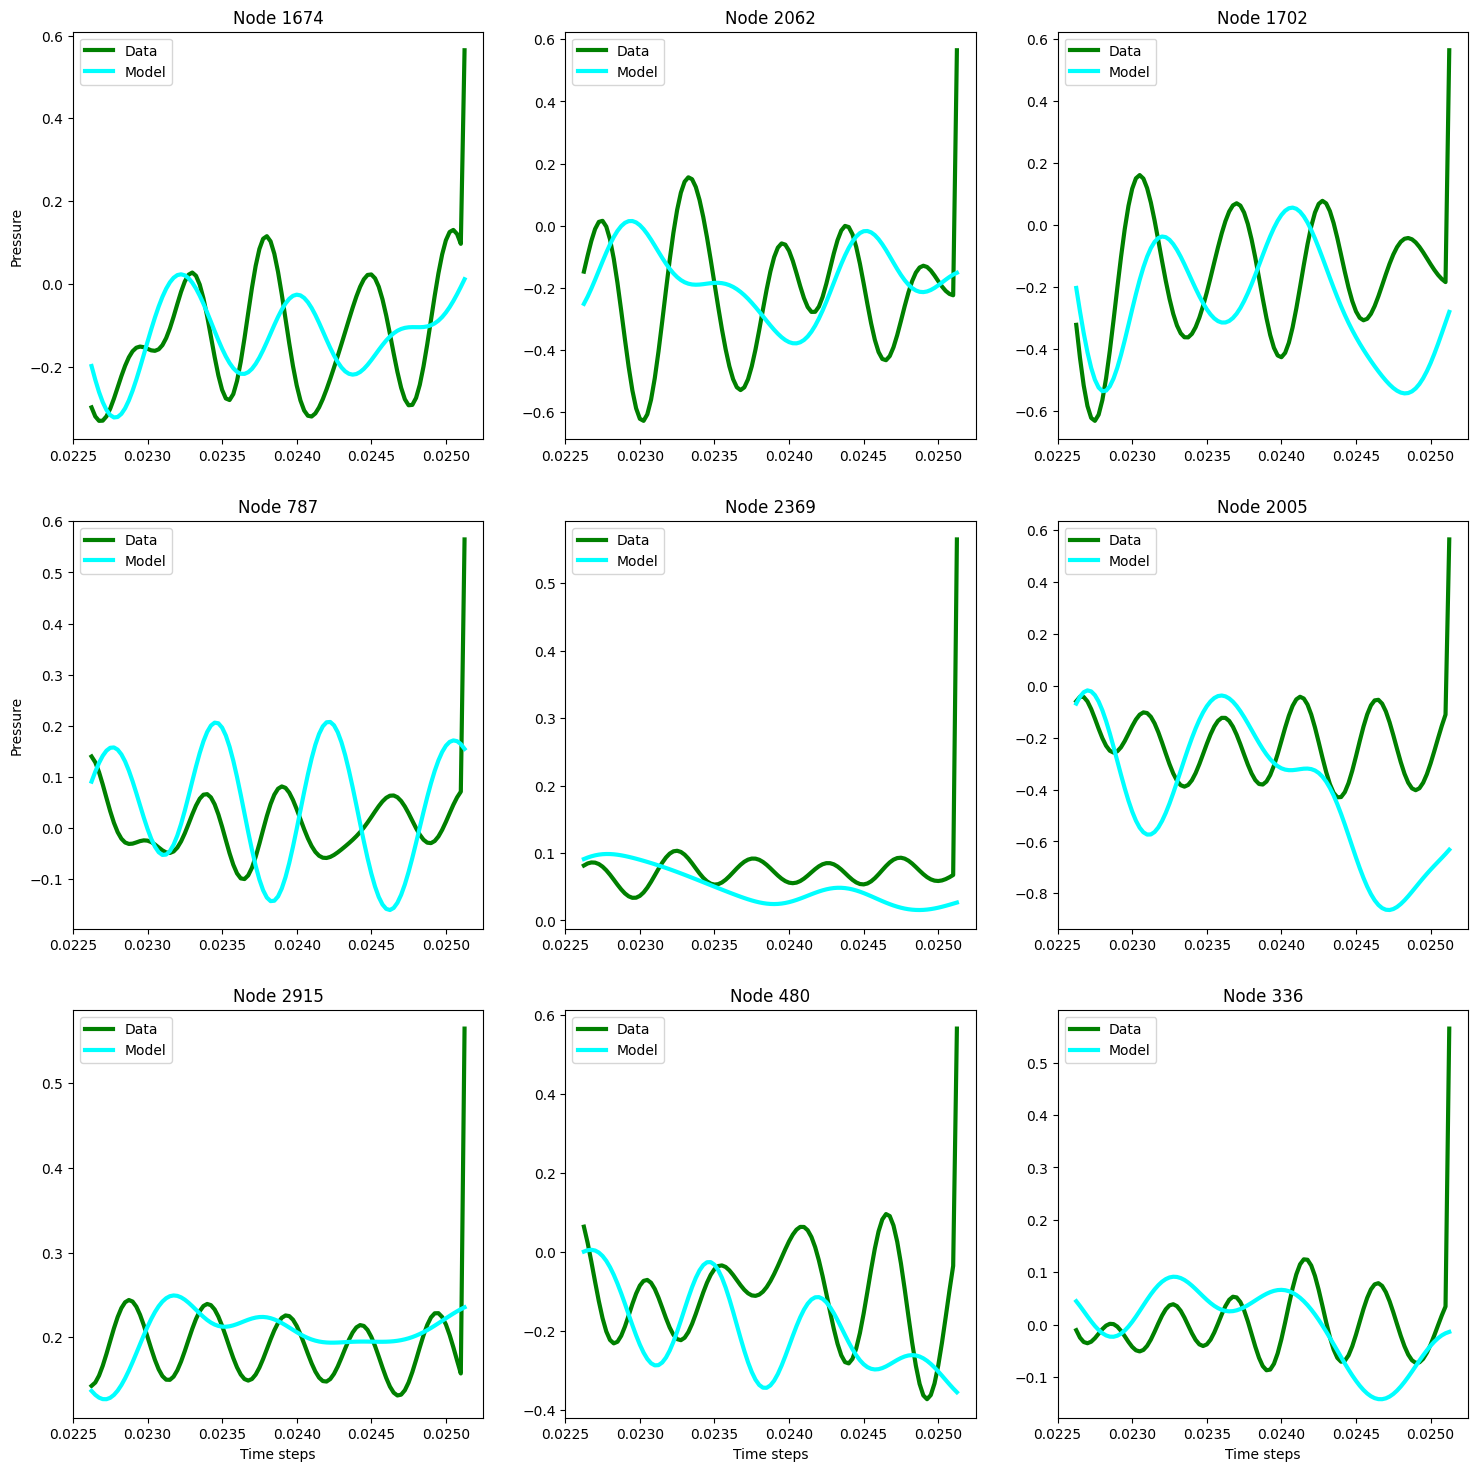

In [24]:
# choose random points in physical domain
points = random.sample(range(opInfData.shape[1]), k = 9)
# create figure. 'ax' is (3, 3) array of Axes
fig, ax = plt.subplots(3, 3, figsize = (18, 18))
# iterate in subplots
for (plotID, (axis, point)) in enumerate(zip(ax.flatten(), points)):
  axis.plot(timeTest, opInfData[-timeTest.shape[0]:, point],
    label = "Data", color = 'green', linewidth = 3
  )
  axis.plot(timeTest, reconstructIntTest[-timeTest.shape[0]:, point],
    label = "Model", color = 'cyan', linewidth = 3
  )
  axis.set_title(f"Node {point}")
  axis.legend()
  if plotID in [6, 7, 8]:
    axis.set_xlabel("Time steps")
  elif plotID in [0, 3, 6]:
    axis.set_ylabel("Pressure")

# Test Dataset

In [10]:
right_operator = ClassWrapper(KS_op)
solver = LSODA(right_operator)

initial_time = time.time()
estimated_field_test = solver.run(KS_data_train[-1], t_data_test[0:1000])
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

NameError: name 'KS_op' is not defined

In [ ]:
# Returning to 512 dimensions

reconstructed_data_test = pipeline.reconstruct_data(data=estimated_field_test)
data_test = pipeline.reconstruct_data(data=KS_data_test)


Applying the global reconstruction strategy.
Applying the global reconstruction strategy.


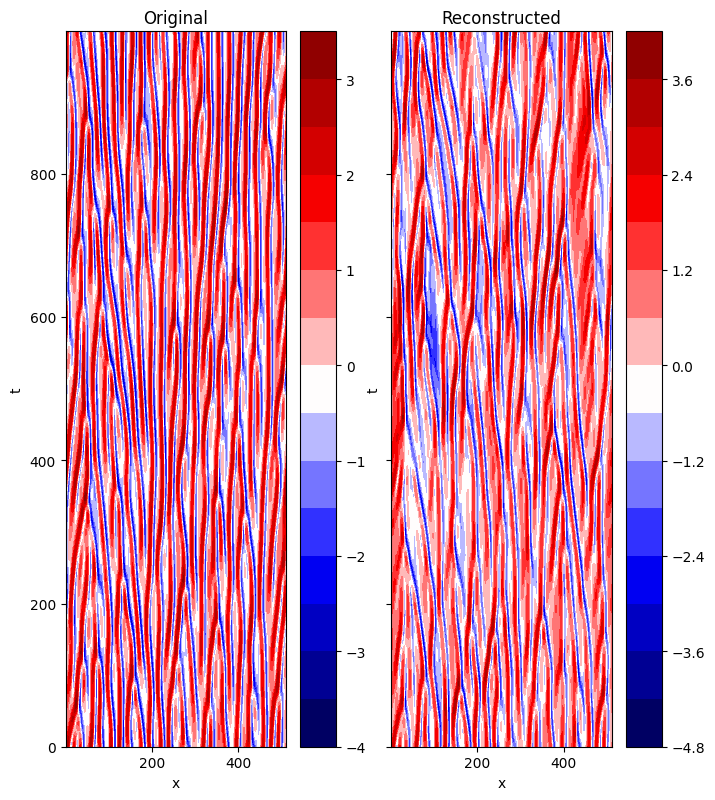

In [ ]:
# Comparing the results

compare_plot(data_test[0:1000], reconstructed_data_test[0:1000],"Original", "Reconstructed")

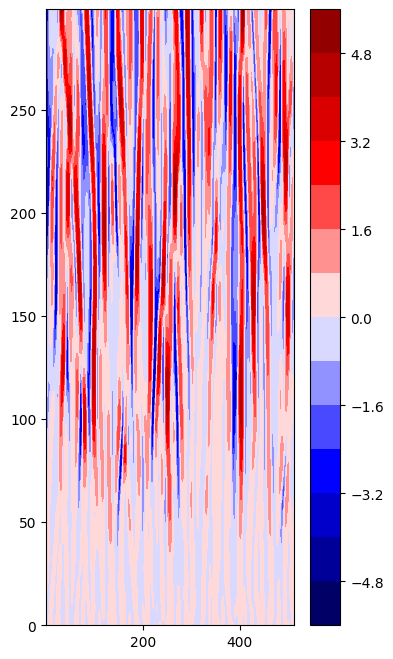

In [ ]:
#plotting the difference between the data

plot(data_test[0:300]-reconstructed_data_test[0:300])

## "View" along time

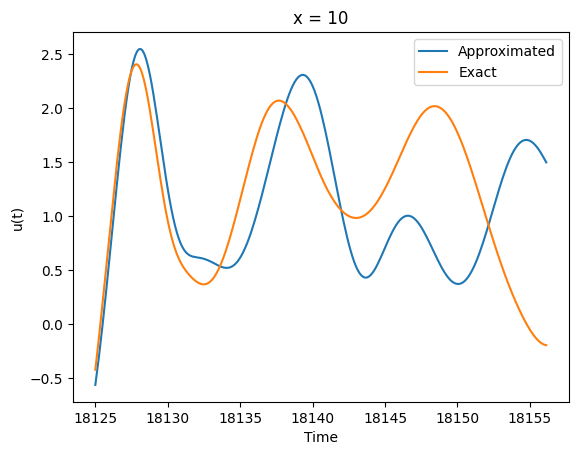

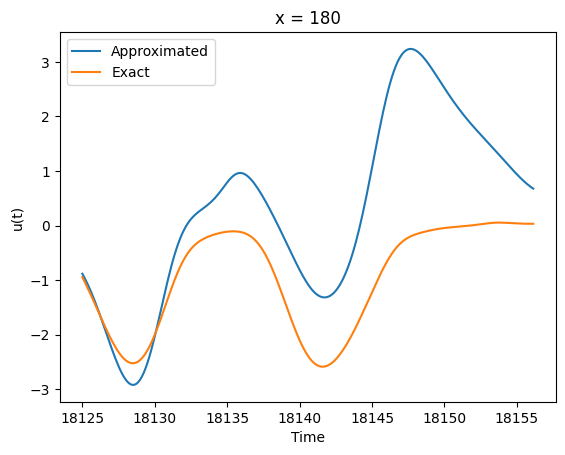

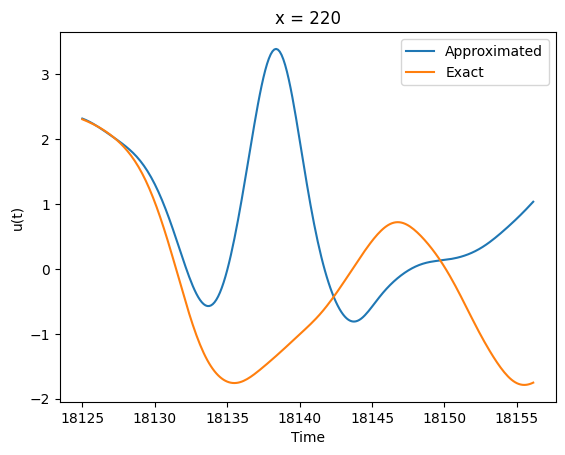

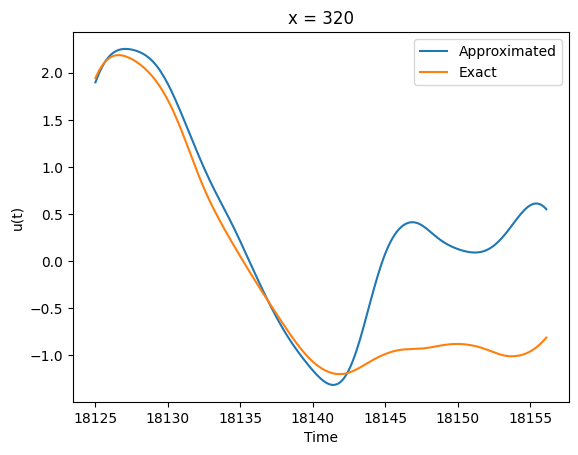

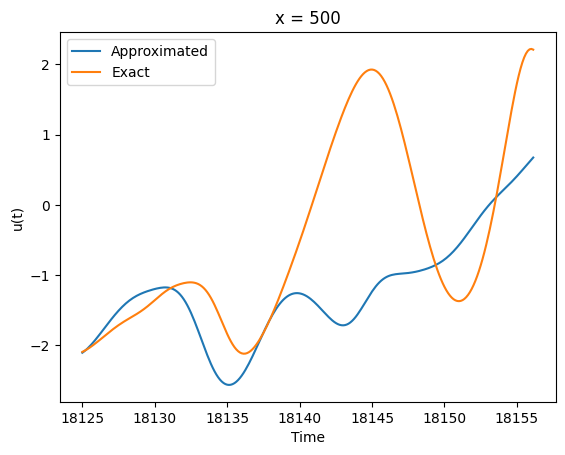

In [ ]:
start = 0
end = 250

samples = [10, 180, 220, 320, 500 ] # x values

for sample in samples:

  time_ref = t_data_test[start:end]
  x = data_test[start:end][:,sample]
  x_aprox = reconstructed_data_test[start:end][:,sample]
  plt.plot(time_ref, x_aprox, label="Approximated")
  plt.plot(time_ref, x, label="Exact")
  plt.xlabel("Time")
  plt.ylabel("u(t)")
  plt.title("x = "+ str(sample))
  plt.legend()
  plt.show()

## "View" along space

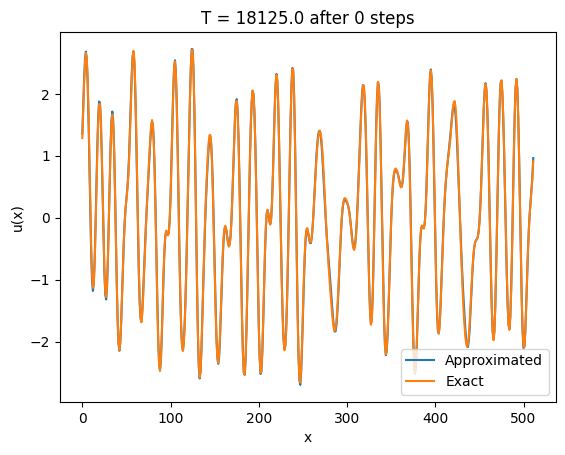

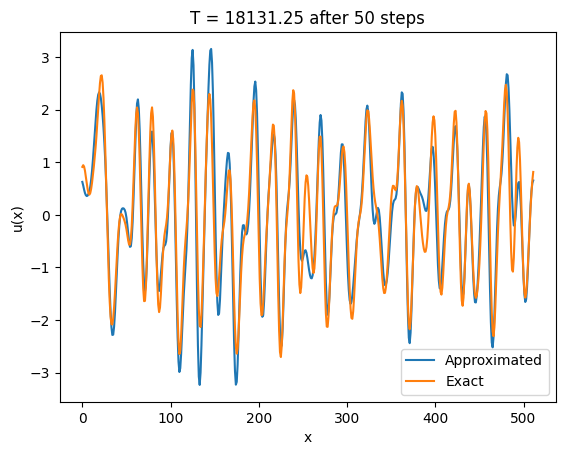

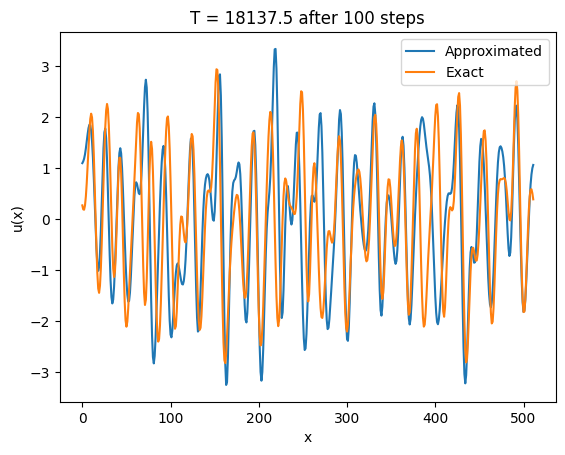

In [ ]:
samples = [0, 50, 100] # t values

for sample in samples:

  x_ref = range(512)
  x = data_test[sample,:]
  x_aprox = reconstructed_data_test[sample,:]

  plt.plot(x_ref, x_aprox, label="Approximated")
  plt.plot(x_ref, x, label="Exact")
  plt.xlabel("x")
  plt.ylabel("u(x)" )
  plt.legend()
  plt.title("T = " + str(t_data_test[sample])+" after " + str(sample) + " steps"  ) 
  plt.show()

# Conclusion

The results of this work for solving the Kuramoto-Sivashinsky problem were obtained by decomposing the initial dataset from 480000, to 150000 samples. Using 90% of the 150000 samples for training, and 10% for testing. The lambdas were chosen by error analysis. Better results can be obtained using the full dataset, which in this case was not used to minimize computational usage.